In [1]:
# import context manager: SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SQLContext
# set up the session

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Ed Squad Project") \
    .config("spark.executor.memory", '200g') \
    .config('spark.executor.cores', '6') \
    .config('spark.cores.max', '8')\
    .config("spark.driver.memory",'32g') \
    .getOrCreate()

sc = spark.sparkContext
        
        
sqlContext = SQLContext(spark)

In [2]:
spark.conf.get("spark.sql.shuffle.partitions")

'200'

In [3]:
import os
os.listdir()
os.getcwd()

'/sfs/qumulo/qhome/smn7ba/ds5110/project'

In [4]:
#import pandas too for visualizations
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', 200000)

In [5]:
%%time
#import mlLib libraries for classification
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder,TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA
from pyspark.mllib.evaluation import MulticlassMetrics,BinaryClassificationMetrics
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

CPU times: user 3.51 ms, sys: 1.52 ms, total: 5.03 ms
Wall time: 4.58 ms


### About data
AMERICAN COMMUNITY SURVEY 2015-2019 5-YEAR SAMPLE <br>
5-in-100 national random sample of the population <br>
Contains all households and persons from the 1% ACS samples for 2015, 2016, 2017, 2018, and 2019 identifiable by year. <br>
The data include persons in group quarters. <br>
This is a weighted sample. <br>
The smallest identifiable geographic unit is the PUMA, containing at least 100,000 persons. PUMAs do not cross state boundaries. <br>
Users should read the FAQ on the multi-year data. <br>


WHERE CAN I GET BETTER GEOGRAPHIC IDENTIFIERS? <br>
The lowest unit of geography in the microdata files is still the PUMA. PUMAs contain at least 100,000 people. <br>
Aggregate data (but not microdata) is currently available from the Census Bureau for geographic areas as small as block groups, but only for the entire 2005-2009 period. <br>


PERNUM numbers all persons within each household consecutively in the order in which they appear on the original census or survey form. <br>
When combined with SAMPLE and SERIAL, PERNUM uniquely identifies each person within the IPUMS. <br>

MULTYEAR identifies the actual year of survey in multi-year ACS/PRCS samples. <br>

<br>
For example, the 3-year ACS and PRCS data files each include cases from three single-year files. <br>
For these multi-year samples, the YEAR variable identifies the last year of data (2007 for the 2005-2007 3-year data; 2008 for the 2006-2008 data; and so on). <br>
MULTYEAR gives the single-year sample from which the case was drawn (2005, 2006, or 2007 for the 2005-2007 3-year data; 2006, 2007, or 2008 for the 2006-2008 3-year data; and so on). <br>

https://usa.ipums.org/usa/acs_multyr.shtml


### Read Data; Create a binary flag; rename columns; Drop if necessary

In [6]:
%%time
seed = 42

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.25 µs


In [7]:
%%time
#import whole data from the census
data = spark.read.csv('/project/ds5559/ds5110_project_snoo/acs_15_19_south.csv', inferSchema="true", header="true")

CPU times: user 16.1 ms, sys: 11 ms, total: 27 ms
Wall time: 2min 17s


In [8]:
%%time
#writing a user defined function to create a Educated or Not Flag - if EDUC>6 then it is 1 and if not 0
#https://towardsdatascience.com/5-ways-to-add-a-new-column-in-a-pyspark-dataframe-4e75c2fd8c08
def EDUCFunc(value):
  if   value > 6: 
      return 1
  else:
      return 0

#create the function to be applied and create a new column EDUC_FLAG
udfsomefunc = F.udf(EDUCFunc, IntegerType())
data = data.withColumn("EDUC_FLAG", udfsomefunc("EDUC"))
#see sample data
data.select('EDUC_FLAG').show(2)

+---------+
|EDUC_FLAG|
+---------+
|        0|
|        1|
+---------+
only showing top 2 rows

CPU times: user 7.74 ms, sys: 739 µs, total: 8.48 ms
Wall time: 1.09 s


In [10]:
%%time
#check the count for EDUC>6 or verify if flag was populated correctly
data.filter(data.EDUC>6).count()

CPU times: user 2.89 ms, sys: 3.32 ms, total: 6.21 ms
Wall time: 26.6 s


2470127

In [11]:
%%time
#Verify the flag count. Should match number above
data.filter(data.EDUC_FLAG!=0).count()

CPU times: user 5.78 ms, sys: 1.69 ms, total: 7.47 ms
Wall time: 29.8 s


2470127

In [12]:
%%time
#Verify the EDUC count. To check imbalance in data
data.filter(data.EDUC_FLAG==0).count()

CPU times: user 6.24 ms, sys: 1.14 ms, total: 7.38 ms
Wall time: 29.6 s


3495122

## Balance the data for educ flags

In [9]:
#majority sample is for larger class whee we use a ratio by sampling smaller class count out of larger class count
sampled_majority_df = data.filter(data['EDUC_FLAG']==0)\
    .sample(False,data.filter(data['EDUC_FLAG']==1).count()/data.filter(data['EDUC_FLAG']==0).count(), seed=seed)
#minor sample is kept as is
minor_df = data.filter(data['EDUC_FLAG']==1).sample(False,1.0, seed=seed)
#combine both in a dataframe for a balanced sample
combined_df = sampled_majority_df.unionAll(minor_df)

In [10]:
#check results
combined_df.groupBy('EDUC_FLAG').count().show()

+---------+-------+
|EDUC_FLAG|  count|
+---------+-------+
|        1|2470127|
|        0|2470573|
+---------+-------+



In [10]:
%%time
#renaming dependent variable to label because the classfier is not recognizing other names. Skip thsi if you are trying other classifiers
df = combined_df.withColumn("label",data.EDUC_FLAG) \
      .drop("EDUC_FLAG")

CPU times: user 1.43 ms, sys: 1.53 ms, total: 2.96 ms
Wall time: 71.1 ms


In [15]:
#Define variables which will be consistently used
split_ratio = [0.7,0.3]
numFolds = 5
threads = 6

rf = RandomForestClassifier(labelCol = "label", featuresCol = "scaledFeatures_train")

paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [30, 50]).build()

pca_model = PCA(k=10, inputCol = "scaledFeatures_train", outputCol = "pca_features_cv")

#create a param grid to pass to cross validator 
#k --> number of principal components
#number of treess in rf
#need to add more later
paramGrid_pca = ParamGridBuilder().addGrid(rf.numTrees, [20, 30, 50]).build()

#.addGrid(pca_model.k, [10]) \ 
bcm = MulticlassClassificationEvaluator() #BinaryClassificationEvaluator()

#Identified first 35 variables of interest
'''
keep_35 = ["HHTYPE","REGION","STATEFIP","COUNTYFIP","METRO","COSTELEC","COSTGAS","COSTWATR","COSTFUEL","FOODSTMP","CINETHH","CILAPTOP",\
        "CISMRTPHN","CITABLET","VEHICLES","COUPLETYPE","NFAMS","NMOTHERS","NFATHERS","CITIZEN","YRSUSA1","RACAMIND","RACASIAN","RACBLK","RACPACIS"\
        ,"RACWHT","RACOTHER","HCOVANY","EMPSTAT","LABFORCE","CLASSWKR","UHRSWORK","VETSTAT","TRANWORK","GCHOUSE","label","MULTYEAR"]
'''

'\nkeep_35 = ["HHTYPE","REGION","STATEFIP","COUNTYFIP","METRO","COSTELEC","COSTGAS","COSTWATR","COSTFUEL","FOODSTMP","CINETHH","CILAPTOP",        "CISMRTPHN","CITABLET","VEHICLES","COUPLETYPE","NFAMS","NMOTHERS","NFATHERS","CITIZEN","YRSUSA1","RACAMIND","RACASIAN","RACBLK","RACPACIS"        ,"RACWHT","RACOTHER","HCOVANY","EMPSTAT","LABFORCE","CLASSWKR","UHRSWORK","VETSTAT","TRANWORK","GCHOUSE","label","MULTYEAR"]\n'

### Reusable Functions to create sample data, split data, preprocess train, tst, fit model and generate classfication metrics and CM

In [16]:
def createSampleData(df,cols,sampleweight):
    df_small = df.select(cols)
    sampled = df_small.sampleBy("MULTYEAR", fractions={2015:sampleweight, 2016: sampleweight, 2017:sampleweight, 2018:sampleweight, 2019:sampleweight}, seed=seed)
    return sampled

def splitData(dataframe,split_ratio,seed):
    training_data, test_data = dataframe.randomSplit(split_ratio, seed=seed)
    cached_tr = training_data.cache()
    cached_test = test_data.cache()
    return cached_tr,cached_test

def preProcessTrainFit(cached_tr,model,pca_model,paramGrid,evaluator,numFolds,seed ):
    #Assemble traininngdata
    #pass all the features into vector assembler to create a vector format to pass to the classification model
    selected_cols=[cols for cols in cached_tr.columns if cols not in['label','MULTYEAR']]
    assembler = VectorAssembler(inputCols=selected_cols, outputCol="features") 
    #scale
    scaler_train = StandardScaler(inputCol="features", outputCol="scaledFeatures_train")

    #creating a pipeline with the assembler,scaler and model to use in the cross validator
    if pca_model is None:  print("Not PCA"); ppl_cv = Pipeline(stages = [assembler,scaler_train, model])
        
    else: 
        print("PCA");
        rf = RandomForestClassifier(labelCol = "label", featuresCol = "pca_features_cv")
        ppl_cv = Pipeline(stages = [assembler,scaler_train,pca_model, rf])

    #passs the model with variosu combinations of the parameters and it will pick the best one. Using 3 folds to save time. Check seed=42.
    crossval = CrossValidator(estimator = ppl_cv,\
                                            estimatorParamMaps=paramGrid,\
                                            evaluator = evaluator ,\
                                            numFolds= numFolds,seed=seed,parallelism=threads)
    #this is our best model - fit the training data
    #https://spark.apache.org/docs/2.3.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator
    return crossval.fit(cached_tr)
    

def preProcessTest(test_data):
    #prepare test data to test predictions
    selected_cols=[cols for cols in test_data.columns if cols not in['label','MULTYEAR']]
    assembler_test = VectorAssembler(inputCols=selected_cols, outputCol="features") 
    transformed_test = assembler_test.transform(test_data)
    #register table as sql table and keep only columns fo interest and save in a new dataframe. This can be done without using SQl as well.
    transformed_test.registerTempTable('transformed_tbl_test')
    transformed_df_test = sqlContext.sql('select label,features from transformed_tbl_test')
    #scale test data
    scaler_test = StandardScaler(inputCol="features", outputCol="scaledFeatures",withStd=False, withMean=True)
    scalerModel_test = scaler_test.fit(transformed_df_test)
    scaledData_test = scalerModel_test.transform(transformed_df_test)
    
    return scaledData_test

In [17]:
#https://runawayhorse001.github.io/LearningApacheSpark/classification.html
#https://shihaojran.com/distributed-machine-learning-using-pyspark/
#https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
# Calculate the elements of the confusion matrix
#https://runawayhorse001.github.io/LearningApacheSpark/classification.html#random-forest-classification

def createLabelsCM(preds):
    
    ##saving labels in a list to pass to the plot
    class_temp = preds.select("label").groupBy("label")\
                            .count().sort('count', ascending=False).toPandas()
    class_temp = class_temp["label"].values.tolist()
    y_true = preds.select("label")
    y_true = y_true.toPandas()

    y_pred = preds.select("prediction")
    y_pred = y_pred.toPandas()

    return confusion_matrix(y_true, y_pred,class_temp)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def classificationMetrics(preds, evaluator):
    #calcualte classification report
    TN = preds.filter('prediction = 0 AND label = prediction').count()
    TP = preds.filter('prediction = 1 AND label = prediction').count()
    FN = preds.filter('prediction = 0 AND label <> prediction').count()
    FP = preds.filter('prediction = 1 AND label <> prediction').count()
    # show confusion matrix
    preds.groupBy('label', 'prediction').count().show()
    # calculate metrics by the confusion matrix
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F =  2 * (precision*recall) / (precision + recall)
    # calculate auc
    #auc = evaluator.evaluate(preds, {evaluator.metricName: 'areaUnderROC'})
    print('n precision: %0.3f' % precision)
    print('n recall: %0.3f' % recall)
    print('n accuracy: %0.3f' % accuracy)
    print('n F1 score: %0.3f' % F)
    #print('AUC: %0.3f' % auc)

### EDA

In [25]:
#displaying number of rows and columns in the data
print((df.count(), len(df.columns)))

(4940700, 206)


### Preprocess

In [28]:
#map to create meanign ful table # wip
'''
hhtype_dict = {'0':'N/A',\
            '1': 'Married-couple family household',\
            '2': 'Male householder, no wife present',\
            '3': 'Female householder, no husband present',\
            '4': 'Male householder, living alone',\
            '5': 'Male householder, not living alone',\
            '6': 'Female householder, living alone',\
            '7': 'Female householder, not living alone',\
            '9': 'HHTYPE could not be determined'}
'''

"\nhhtype_dict = {'0':'N/A',            '1': 'Married-couple family household',            '2': 'Male householder, no wife present',            '3': 'Female householder, no husband present',            '4': 'Male householder, living alone',            '5': 'Male householder, not living alone',            '6': 'Female householder, living alone',            '7': 'Female householder, not living alone',            '9': 'HHTYPE could not be determined'}\n"

In [29]:
#sampled.select('HHTYPE').rdd.map(lambda x: hhtype_dict.get(x) ).take(5)

In [21]:
%%time
##aggregating counts by Year and HHtype for sampple dataset - add labels - convert to visualization
#sampled_n = sampled.select('HHTYPE').rdd.map(lambda x: hhtype_dict.get(x) )
#sampled.filter((sampled.HHTYPE!=0) & (sampled.HHTYPE!=9)).groupBy('MULTYEAR','HHTYPE').count()\
    #.orderBy('MULTYEAR','count', ascending=False).show(100,truncate=False)
sampled.filter((sampled.HHTYPE!=0) & (sampled.HHTYPE!=9)).groupBy('HHTYPE').count()\
    .orderBy('count', ascending=False).show(100,truncate=False)

+------+------+
|HHTYPE|count |
+------+------+
|1     |355432|
|3     |75402 |
|6     |39112 |
|4     |27451 |
|2     |20845 |
|5     |7654  |
|7     |6213  |
+------+------+

CPU times: user 10.2 ms, sys: 6.68 ms, total: 16.9 ms
Wall time: 1min 38s


In [18]:
#removing cols which are repeated and may be hoighly correlated so that PCA components are more meaningful
cols = df.drop('_c0','EDUC','CLUSTER','CBSERIAL','STRATA','HHWT','EDUCD',\
 'QCOSTELE',\
 'QCOSTFUE',\
 'QCOSTGAS',\
 'QCOSTWAT',\
 'QFOODSTM',\
 'QINSINCL',\
 'QMORTGAG',\
 'QOWNERSH',\
 'QPROPINS',\
 'QTAXINCL',\
 'QVALUEH',\
 'QFUELHEA',\
 'QCIDIAL',\
 'QCILAPTOP',\
 'QCINETHH',\
 'QCIOTHSVC',\
 'QCISAT',\
 'QCISMRTPHN',\
 'QCITABLET',\
 'QCIDATAPLN',\
 'QVEHICLE',\
 'QAGE',\
 'QMARRNO',\
 'QMARST',\
 'QRELATE',\
 'QSEX',\
 'QYRMARR',\
 'QBPL',\
 'QCITIZEN',\
 'QHISPAN',\
 'QRACE',\
 'QYRNATUR',\
 'QHINSEMP',\
 'QHINSPUR',\
 'QHINSTRI',\
 'QHINSCAI',\
 'QHINSCAR',\
 'QHINSVA',\
 'QHINSIHS',\
 'QEDUC',\
 'QGRADEAT',\
 'QDEGFIELD',\
 'QSCHOOL',\
 'QCLASSWK',\
 'QEMPSTAT',\
 'QIND',\
 'QOCC',\
 'QUHRSWOR',\
 'QINCEARN',\
 'QINCBUS',\
 'QINCINVS',\
 'QINCOTHE',\
 'QINCRETI',\
 'QINCSS',\
 'QINCSUPP',\
 'QINCTOT',\
 'QFTOTINC',\
 'QINCWAGE',\
 'QINCWELF',\
 'QVETSTAT',\
 'QCARPOOL',\
 'QDEPARTS',\
 'QPWSTAT2',\
 'QRIDERS',\
 'QTRANTIM',\
 'QTRANWOR',\
 'QGCHOUSE',\
 'QGCMONTH',\
 'QGCRESPO',\
 'INCSUPP',\
 'INCWAGE',\
 'INCBUS00',\
 'INCSS',\
 'INCWELFR',\
 'INCINVST',\
 'INCRETIR',\
 'INCSUPP',\
 'INCOTHER',\
 'INCEARN',\
 'RACE',\
 'RACED',\
 'SEI',\
 'CLASSWKRD',\
 'GRADEATTD',\
 'EMPSTATD',\
 'MULTGEND',\
 'OWNERSHPD',\
 'BPLD',\
 'YEAR','SAMPLE','SERIAL','PERNUM','MULTYEAR').columns
#spark.createDataFrame(cols,StringType()).toPandas()

In [19]:
#sampling data to use more effeciently; seed = 42
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.sampleBy.html
#https://towardsdatascience.com/exploratory-data-analysis-eda-with-pyspark-on-databricks-e8d6529626b1
#https://www.kaggle.com/tientd95/advanced-pyspark-for-exploratory-data-analysis
selected_cols=[cols for cols in cols if cols not in['label']]
sampled = createSampleData(df,cols,0.1)

In [20]:
%%time
corr_df = sampled.toPandas()[selected_cols]

CPU times: user 17.2 s, sys: 1.64 s, total: 18.8 s
Wall time: 2min 37s


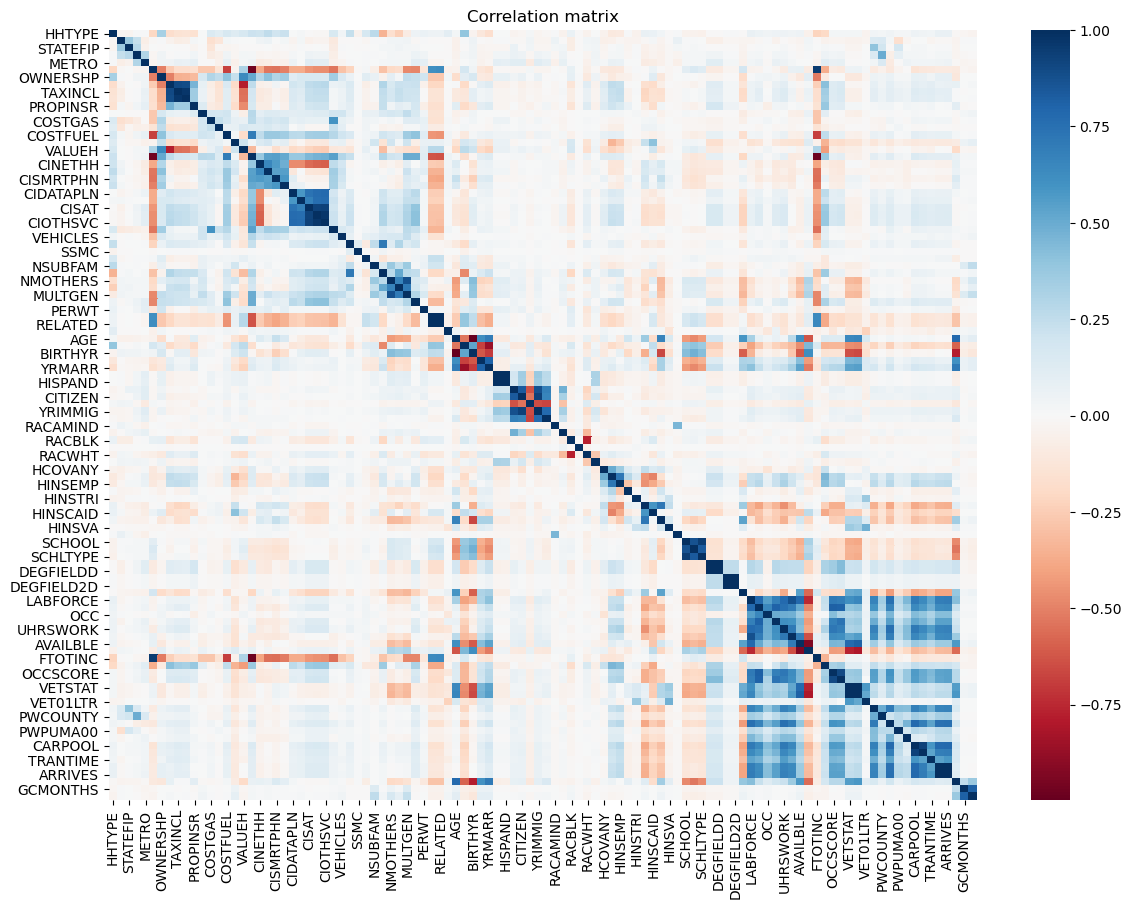

In [27]:
#https://plotly.com/python/pca-visualization/
corr = corr_df.corr()
plt.figure(figsize = (14, 10))
sns.heatmap(corr, cmap="RdBu",annot = False)
            #xticklabels=corr.columns.values,
            #yticklabels=corr.columns.values)
plt.title('Correlation matrix')
plt.show()
#cadd code orrect columns to appear uniformly on access

### Random Forest Model with dimension reduction (PCA)

In [21]:
%%time
#split data
cached_tr_pca, cached_test_pca = splitData(sampled,split_ratio,seed)

#preprocesstrain
cv_model_pca = preProcessTrainFit(cached_tr_pca,rf,pca_model,paramGrid_pca,bcm,numFolds,seed)

#preprocess test
scaled_test_pca = preProcessTest(cached_test_pca)

PCA
CPU times: user 2.07 s, sys: 543 ms, total: 2.61 s
Wall time: 16min 18s


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|14382|
|    0|       0.0|54004|
|    1|       1.0|59184|
|    0|       1.0|19563|
+-----+----------+-----+

n precision: 0.752
n recall: 0.805
n accuracy: 0.769
n F1 score: 0.777


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


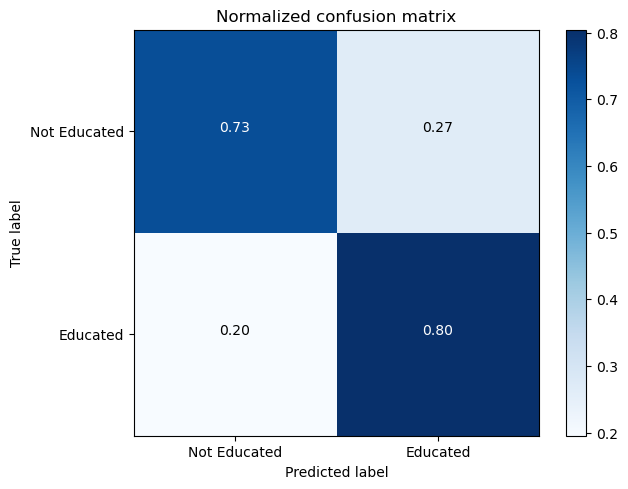

In [22]:
#select the best model ffro mthe cross validator
bestPipeline = cv_model_pca.bestModel

#creating a new dataframe wiith labels features and predictions
predictions = bestPipeline.transform(cached_test_pca)

#Metrics
#call classification metrics method to print metrics
classificationMetrics(predictions,bcm)

# Plot normalized confusion matrix
cnf_matrix = createLabelsCM(predictions)
plot_confusion_matrix(cnf_matrix, classes=['Not Educated','Educated'], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

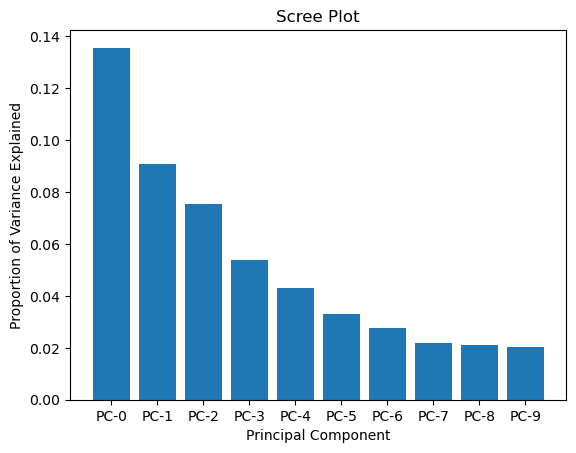

In [23]:
##PCA Loadings
pipe = bestPipeline.stages[2]
exp_var = pipe.explainedVariance
#print("Explained Variance: ",exp_var)
data_scaled = bestPipeline.stages[1]
#https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
#print(pd.DataFrame(pipe.pc,columns=pd.DataFrame(data_scaled).columns,index = ['PC-0','PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9']))
#https://www.py4u.net/discuss/218858
#https://datascience-enthusiast.com/Python/PCA_Spark_Python_R.html
rows = pipe.pc.toArray().tolist()
pca_components=['PC-0','PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9']
#screeplot
plt.bar(pca_components,exp_var)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [ ]:
#create a spark dataframe with pca loadings, componetns and column names for further analysis
df_pca = spark.createDataFrame(rows,pca_components)
df_pandas = df_pca.toPandas()
df_pandas.index = selected_cols
df_pandas.sort_values(by='PC-0', ascending=False)

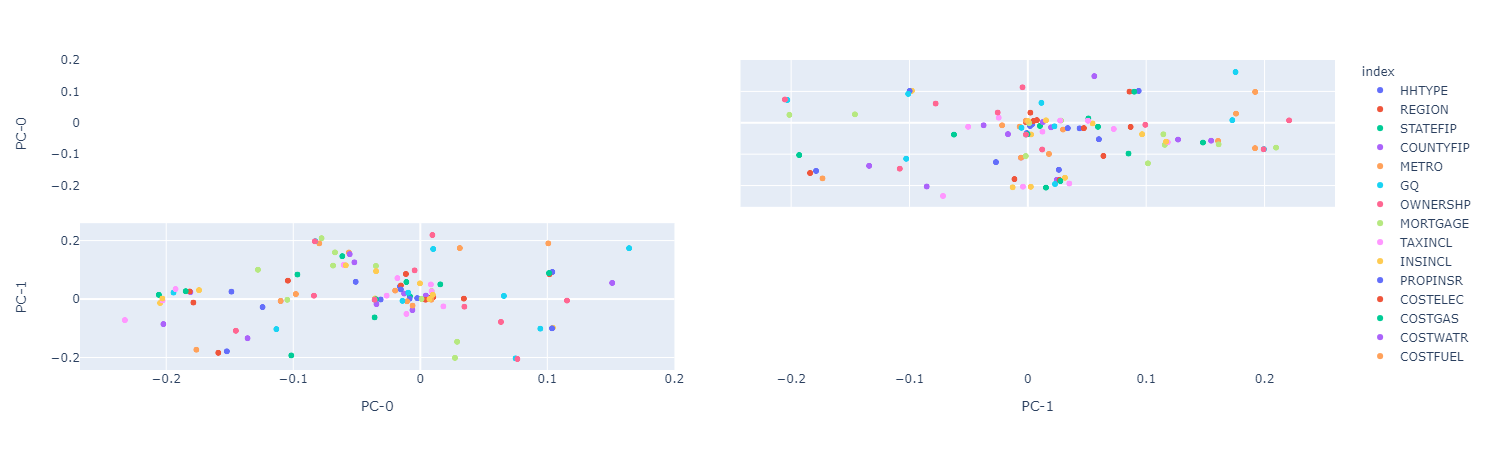

In [39]:
fig = px.scatter_matrix(
    df_pandas,
    dimensions=['PC-0','PC-1'],
    color=df_pandas.index
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [25]:
#save top 5 and bottom 10 loadings so that it gives positive and negative loadings
lb0_pos = df_pandas.sort_values('PC-0', ascending=True).head(5).index.str.cat(sep=' ')
lb0_neg = df_pandas.sort_values('PC-0', ascending=False).head(5).index.str.cat(sep=' ')
lb1_pos = df_pandas.sort_values('PC-1', ascending=True).head(5).index.str.cat(sep=' ')
lb1_neg = df_pandas.sort_values('PC-1', ascending=False).head(5).index.str.cat(sep=' ')
'''
lb2_pos = df_pandas.sort_values('PC-2', ascending=True).head(5).index.str.cat(sep=' ')
lb2_neg = df_pandas.sort_values('PC-2', ascending=False).head(5).index.str.cat(sep=' ')
lb3_pos = df_pandas.sort_values('PC-3', ascending=True).head(5).index.str.cat(sep=' ')
lb3_neg = df_pandas.sort_values('PC-3', ascending=False).head(5).index.str.cat(sep=' ')
lb4_pos = df_pandas.sort_values('PC-4', ascending=True).head(5).index.str.cat(sep=' ')
lb4_neg = df_pandas.sort_values('PC-4', ascending=False).head(5).index.str.cat(sep=' ')
'''

In [32]:
#print results
print('PC0+', lb0_pos)
print('PC0-', lb0_neg)
print('PC1+', lb1_pos)
print('PC1-', lb1_neg)
'''
print('PC2+', lb2_pos)
print('PC2-', lb2_neg)
print('PC3+', lb3_pos)
print('PC3-', lb3_neg)
print('PC4+', lb4_pos)
print('PC4-', lb4_neg)
'''

PC0+ LABFORCE UHRSWORK CLASSWKR HWSEI OCCSCORE
PC0- INCTOT MARST HINSCAID RELATE SCHOOL
PC1+ FTOTINC GQ EMPSTAT AGE VETSTATD
PC1- MULTGEN FRIDGE CIDIAL CIOTHSVC BIRTHYR


"\nprint('PC2+', lb2_pos)\nprint('PC2-', lb2_neg)\nprint('PC3+', lb3_pos)\nprint('PC3-', lb3_neg)\nprint('PC4+', lb4_pos)\nprint('PC4-', lb4_neg)\n"

In [36]:
#look at the chosen model and models in all the folds and with all params
rf_model = bestPipeline.stages[3]
importances_rf = rf_model.featureImportances
print(rf_model)

#all the 9 model accuracies. The max one was picked as best
avgMetricsGrid = cv_model_pca.avgMetrics
print(avgMetricsGrid)

#https://tsmatz.github.io/azure-databricks-exercise/exercise04-hyperparams-tuning.html
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html
# View all results (accuracy) by each params - these can be converted to pretty tables in pandas later
list(zip(cv_model_pca.getEstimatorParamMaps()))

RandomForestClassificationModel: uid=RandomForestClassifier_4bdd18b2f66b, numTrees=20, numClasses=2, numFeatures=10
[0.769991656028584, 0.769991656028584, 0.769991656028584]


[({Param(parent='RandomForestClassifier_50f5754027d7', name='numTrees', doc='Number of trees to train (>= 1).'): 20},),
 ({Param(parent='RandomForestClassifier_50f5754027d7', name='numTrees', doc='Number of trees to train (>= 1).'): 30},),
 ({Param(parent='RandomForestClassifier_50f5754027d7', name='numTrees', doc='Number of trees to train (>= 1).'): 50},)]

In [38]:
importances_rf

SparseVector(10, {0: 0.5544, 1: 0.137, 2: 0.012, 3: 0.0319, 4: 0.0014, 5: 0.0333, 6: 0.1257, 7: 0.0948, 8: 0.0025, 9: 0.0071})

### Model selective features based on PC-0 component

In [28]:
%%time
#create sample dataframe
keep_pca =['LABFORCE', 'UHRSWORK', 'OCCSCORE', 'CLASSWKR', 'HWSEI',\
           'INCTOT', 'MARST', 'HINSCAID','RELATE','SCHOOL', 'label']
#'TRANTIME', 'RELATE', 'OCCSCORE', 'UHRSWORK','PWSTATE','NMOTHERS','NFATHERS',DEGFIELDD
sampled_pca = createSampleData(df,keep_pca,0.1)

#split data
cached_tr, cached_test = splitData(sampled_pca,split_ratio,seed)

#preProcessTrain data and fit
model_short = preProcessTrainFit(cached_tr,rf,None,paramGrid,bcm,numFolds,seed)

#preprocess testdata
scaled_test = preProcessTest(cached_test)

Not PCA
CPU times: user 1.09 s, sys: 283 ms, total: 1.38 s
Wall time: 6min 4s


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|21058|
|    0|       0.0|58234|
|    1|       1.0|52991|
|    0|       1.0|15995|
+-----+----------+-----+

n precision: 0.768
n recall: 0.716
n accuracy: 0.750
n F1 score: 0.741


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


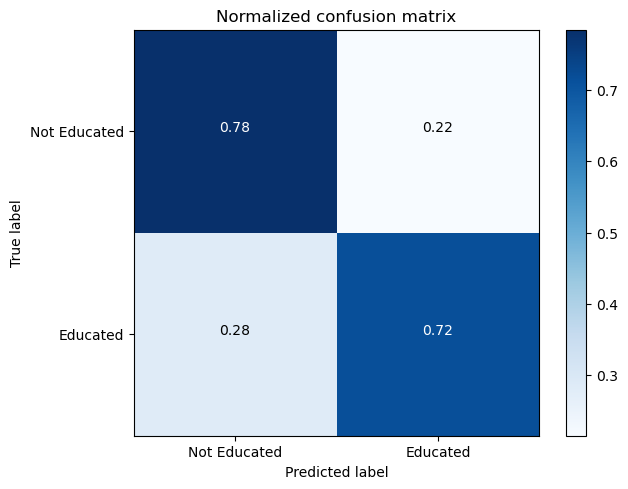

In [29]:
#predictions
bestPipeline_short = model_short.bestModel
pipe_short = bestPipeline_short.stages[1]
predictions_short = bestPipeline_short.transform(cached_test)
classificationMetrics(predictions_short,bcm)

#Visualize Metrics
cnf_matrix_short= createLabelsCM(predictions_short)
plot_confusion_matrix(cnf_matrix_short, classes=['Not Educated','Educated'], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

### Checking Feature Importance to improve the model by removing features which are not important

In [43]:
selected_cols_imp

['LABFORCE',
 'UHRSWORK',
 'OCCSCORE',
 'CLASSWKR',
 'HWSEI',
 'INCTOT',
 'MARST',
 'HINSCAID',
 'RELATE',
 'SCHOOL']

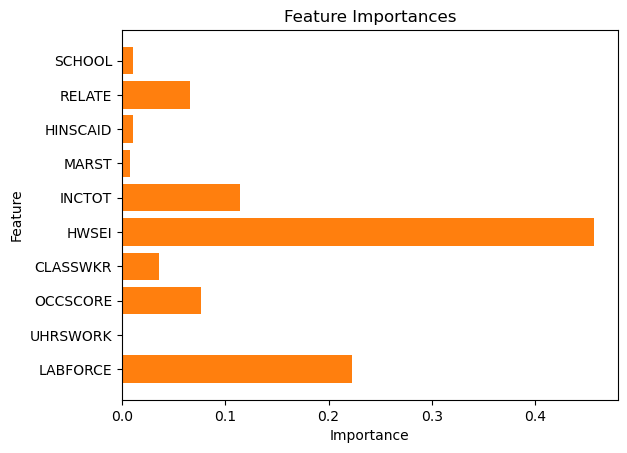

In [44]:
bestModel = bestPipeline_short.stages[2]
importances = bestModel.featureImportances
x_values = list(range(len(importances)))
selected_cols_imp=[cols for cols in keep_pca if cols not in['label']]
plt.barh(x_values,importances);
plt.yticks(x_values,selected_cols_imp, rotation=0);
plt.ylabel('Feature');
plt.xlabel('Importance');
plt.title('Feature Importances');
plt.show();

In [35]:
#References
#https://towardsdatascience.com/pre-process-data-with-pipeline-to-prevent-data-leakage-during-cross-validation-e3442cca7fdc
#https://awesomeopensource.com/project/adornes/spark_python_ml_examples
#https://spark.apache.org/docs/latest/ml-tuning.html
#https://sparkbyexamples.com/pyspark/pyspark-rename-dataframe-column/
#https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier
#https://people.stat.sc.edu/haigang/sparkCaseStudy.html